# Binary Classification

## Import Dependencies

In [208]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [209]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

--2023-02-13 18:43:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-13 18:43:18 (73.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Get the data

In [210]:
df = pd.read_csv('/content/drive/MyDrive/Tensorflow_Certificate/spam.csv')

In [211]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preprocess

### Label Encoding

Note: Since the label is text, we need to encode it

In [212]:
# Label Encoding for Label Column
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['label_encoded'] = labelencoder.fit_transform(df['label'])

In [213]:
df.head()

,label,text,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [214]:
df['label'].value_counts()
# df['label'].nunique()

ham     4825
spam     747
Name: label, dtype: int64

In [215]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(labelencoder.classes_)
class_names = labelencoder.classes_
num_classes, class_names

(2, array(['ham', 'spam'], dtype=object))

### Convert to Lower Case

As a dimensionality reduction

In [216]:
# df['text'] = df['text'].map(lambda x: )

## Split the data

In [257]:
from sklearn.model_selection import train_test_split

train_sent,test_sent,train_labels_1,test_labels_1 = train_test_split(df['text'].to_numpy(),
                                                                 df['label_encoded'].to_numpy(),
                                                                 random_state=42,
                                                                 test_size=0.1)

In [258]:
len(train_sent),len(test_sent),len(train_labels_1),len(test_labels_1)

(5014, 558, 5014, 558)

## Text Vectorization

### Finding output Sequence Length

In [259]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sent]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

15.522337455125648

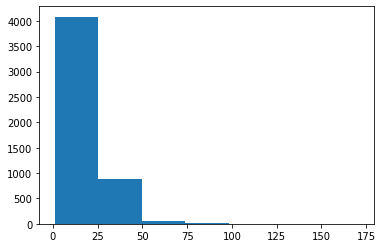

In [260]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [261]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

32

### Finding Vocab Length

In [262]:
# Concatinating all the words to a single list
master_vocab_list = []
for sent in df['text']:
  master_vocab_list = master_vocab_list + sent.split()

In [263]:
# Checking the length of all tokens (words)
len(master_vocab_list)

86335

In [264]:
# Checking the length of unique tokens
len(set(master_vocab_list))

15585

### Creating Vectorizer

In [265]:
# Setup text vectorization variables
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 15585
max_length = 32

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, #How many different words in the vocabulary (automatically add <oov>)
                                    standardize = 'lower_and_strip_punctuation',
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=max_length, # how long do you want your sequence to be
                                    )

### Fitting the vectorizer 

In [266]:
text_vectorizer.adapt(train_sent)

## Text Embedding

In [267]:
# Create token embedding layer
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=max_vocab_length, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

## Creating Data Sets

In [269]:
# Turn our data into TensorFlow Datasets
import tensorflow as tf 

train_dataset_1 = tf.data.Dataset.from_tensor_slices((train_sent, train_labels_1))
test_dataset_1 = tf.data.Dataset.from_tensor_slices((test_sent, test_labels_1))

train_dataset_1

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [270]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset_1 = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_1 = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_1

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [273]:
for review, label in train_dataset_1.take(1):
  print(label.shape)
  print(review.shape)

(32,)
(32,)


In [277]:
for review, label in train_dataset_1.take(1):
  print(label)
  print(review)

tf.Tensor([1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0], shape=(32,), dtype=int64)
tf.Tensor(
[b"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323."
 b"Aight, I'll hit you up when I get some cash"
 b'Don no da:)whats you plan?' b'Going to take your babe out ?'
 b'No need lar. Jus testing e phone card. Dunno network not gd i thk. Me waiting 4 my sis 2 finish bathing so i can bathe. Dun disturb u liao u cleaning ur room.'
 b'Probably, want to pick up more?'
 b'Last Chance! Claim ur \xc3\xa5\xc2\xa3150 worth of discount vouchers today! Text SHOP to 85023 now! SavaMob, offers mobile! T Cs SavaMob POBOX84, M263UZ. \xc3\xa5\xc2\xa33.00 Sub. 16'
 b'K sure am in my relatives home. Sms me de. Pls:-)'
 b"The LAY MAN! Just to let you know you are missed and thought off. Do have a great day. And if you can send me bimbo and ugo's numbers, ill appreciate. Safe"
 b'When you g

## Model 1: Convolutional 1D

In [283]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
print(inputs.shape)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
print(text_vectors.shape)
token_embeddings = token_embed(text_vectors) # create embedding
print(token_embeddings.shape)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
print(x.shape)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
print(outputs.shape)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

(None, 1)
(None, 32)
(None, 32, 128)
(None, 32, 64)
(None, 64)
(None, 1)


In [276]:
# Fit the model
model_1_history = model_1.fit(train_dataset_1,
                              steps_per_epoch=int(0.1 * len(train_dataset_1)), # only fit on 10% of batches for faster training time
                              epochs=5,
                              validation_data=test_dataset_1,
                              validation_steps=int(0.1 * len(test_dataset_1))) # only validate on 10% of batches

Epoch 1/5
15/15 [==============================] - 2s 172ms/step - loss: 0.4866 - accuracy: 0.8583 - val_loss: 0.3705 - val_accuracy: 0.8438
Epoch 2/5
15/15 [==============================] - 2s 113ms/step - loss: 0.2939 - accuracy: 0.8562 - val_loss: 0.3443 - val_accuracy: 0.8438
Epoch 3/5
15/15 [==============================] - 1s 83ms/step - loss: 0.2746 - accuracy: 0.8583 - val_loss: 0.3115 - val_accuracy: 0.8438
Epoch 4/5
15/15 [==============================] - 1s 61ms/step - loss: 0.1931 - accuracy: 0.9083 - val_loss: 0.2498 - val_accuracy: 0.8750
Epoch 5/5
15/15 [==============================] - 1s 45ms/step - loss: 0.1918 - accuracy: 0.9271 - val_loss: 0.1763 - val_accuracy: 0.9375


In [25]:
model_1.evaluate(test_dataset)

18/18 [==============================] - 0s 7ms/step - loss: 0.1512 - accuracy: 0.9588


[0.1511559635400772, 0.958781361579895]

In [26]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs

18/18 [==============================] - 0s 4ms/step


array([[0.38872105],
       [0.24455978],
       [0.2245102 ],
       [0.10750556],
       [0.7202738 ],
       [0.04229472],
       [0.04257994],
       [0.02924063],
       [0.0843886 ],
       [0.03033868],
       [0.05756254],
       [0.39180994],
       [0.03376331],
       [0.02678563],
       [0.0413427 ],
       [0.03211395],
       [0.02922713],
       [0.54767406],
       [0.02315345],
       [0.03280171],
       [0.04922784],
       [0.18099286],
       [0.04579524],
       [0.04500907],
       [0.7834422 ],
       [0.07245027],
       [0.0530734 ],
       [0.03566727],
       [0.0317517 ],
       [0.02676325],
       [0.08582824],
       [0.03555626],
       [0.23874119],
       [0.0441115 ],
       [0.0690066 ],
       [0.05250571],
       [0.02241108],
       [0.1879367 ],
       [0.0265988 ],
       [0.10411517],
       [0.18874913],
       [0.03019678],
       [0.9489095 ],
       [0.03960523],
       [0.04088369],
       [0.0560004 ],
       [0.04868643],
       [0.028

In [27]:
# Convert pred probs to classes
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>

In [28]:
model_1.predict(['We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p'])

1/1 [==============================] - 0s 240ms/step


array([[0.22451018]], dtype=float32)

In [29]:
list(test_dataset)[0][0][2]

<tf.Tensor: shape=(), dtype=string, numpy=b'We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p'>

In [30]:
list(test_dataset)[0][1][2]

<tf.Tensor: shape=(), dtype=int64, numpy=1>

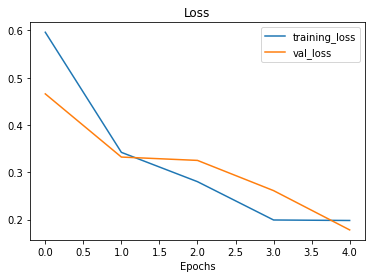

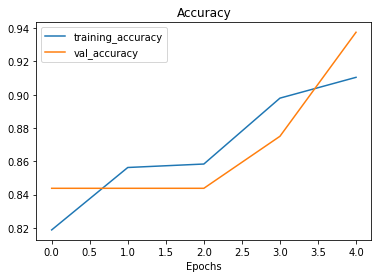

In [31]:
plot_loss_curves(model_1_history)

## To Do: 

1. Fit other Models
2. Create callbacks
3. Save and Load the Model
4. Load from Checkpoint weights
5. Figure out why cannot run for larger epochs

# Multi Class Clssification

https://www.tensorflow.org/datasets/catalog/ag_news_subset

## Downloading TensorFlow dataset

In [306]:
import tensorflow_datasets.public_api as tfds
import tensorflow as tf

In [307]:
train_ds, val_ds, test_ds = tfds.load('ag_news_subset',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True,
                                      batch_size=32
                                      )

In [110]:
# ds = tfds.load('ag_news_subset',
#                                       # split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
#                                       shuffle_files=True, as_supervised=True,
#                                       batch_size=32
#                                       )

In [38]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training samples: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating samples: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing samples: " + str(NUM_TEST_IMAGES))

Num training samples: 84000
Num validating samples: 18000
Num testing samples: 18000


In [308]:
for review_batch, label_batch in train_ds.take(1):
  print(review_batch.shape,label_batch.shape)
  print(type(review_batch))

(32,) (32,)
<class 'tensorflow.python.framework.ops.EagerTensor'>


## Splitting the Data

In [309]:
# Splitting the Review and the Label of the Training Set
train_reviews = []
train_labels = []

for review_batch, label_batch in train_ds:
  for i in range(32):
    train_reviews+=[review_batch[i].numpy()]
    train_labels+=[label_batch[i].numpy()]

In [310]:
# Splitting the Review and the Label of the Test Set
test_reviews = []
test_labels = []

for review_batch, label_batch in test_ds:
  # print(len(review_batch))
  for i in range(len(review_batch)):
    test_reviews+=[review_batch[i].numpy()]
    test_labels+=[label_batch[i].numpy()]

In [311]:
# Splitting the Review and the Label of the Validation Set
valid_reviews = []
valid_labels = []

for review_batch, label_batch in val_ds:
  for i in range(len(review_batch)):
    valid_reviews+=[review_batch[i].numpy()]
    valid_labels+=[label_batch[i].numpy()]

## Text Vectorizatioin

### Finding out Sequence Length

In [312]:
total_length_list = []

for review_batch, label_batch in train_ds:
  for i in range(32):
    total_length_list.append(len(review_batch[i].numpy().split()))

(array([2.6144e+04, 5.5162e+04, 2.2610e+03, 3.1000e+02, 8.6000e+01,
        3.3000e+01, 4.0000e+00]),
 array([  3.        ,  26.57142857,  50.14285714,  73.71428571,
         97.28571429, 120.85714286, 144.42857143, 168.        ]),
 <a list of 7 Patch objects>)

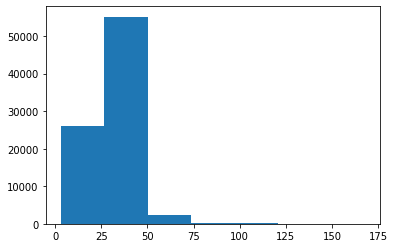

In [313]:
import matplotlib.pyplot as plt
plt.hist(total_length_list,bins=7)

In [314]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(total_length_list, 95))
output_seq_len

45

### Finding Vocab Length

In [315]:
comeplete_vocab = []
for review_batch, label_batch in train_ds:
  for i in range(32):
    comeplete_vocab+=review_batch[i].numpy().split()

In [316]:
# unique number of words (vocab)
len(set(comeplete_vocab))

129411

### Creating the Vectorizer

In [317]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 129411
max_length = output_seq_len

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, #How many different words in the vocabulary (automatically add <oov>)
                                    standardize = 'lower_and_strip_punctuation',
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=max_length, # how long do you want your sequence to be
                                    )

### Fitting the vectorizer

In [318]:
text_vectorizer.adapt(train_reviews)

## Text Embedding

In [319]:
# Create token embedding layer
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=max_vocab_length, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

## Creating Data Sets

In [341]:
# Turn our data into TensorFlow Datasets
import tensorflow as tf 

train_dataset = tf.data.Dataset.from_tensor_slices((train_reviews, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_reviews, test_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_reviews,valid_labels))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [342]:
for review, label in train_dataset.take(1):
  print(label.shape)
  print(review.shape)


()
()


In [343]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
# valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [344]:
for review, label in train_dataset.take(1):
  print(label.shape)
  print(review.shape)

(32,)
(32,)


## Model 0: Baseline (Convo 1D)

In [338]:
from IPython.terminal.embed import embed
# Create Using functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,),dtype=tf.string)
print(inputs.shape)
text_vectors = text_vectorizer(inputs)
print(text_vectors.shape)
embeds = token_embed(text_vectors)
print(embeds.shape)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embeds)
print(x.shape)
x = layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = layers.Dense(1,activation='softmax')(x)
print(outputs.shape)
model_0 = tf.keras.Model(inputs,outputs)

(None, 1)
(None, 45)
(None, 45, 128)
(None, 45, 64)
(None, 64)
(None, 1)


In [339]:
# Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [345]:
model_0.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 45)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 45, 128)          16564608  
                                                                 
 conv1d_30 (Conv1D)          (None, 45, 64)            41024     
                                                                 
 global_average_pooling1d_29  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_28 (Dense)            (None, 1)                 65 

In [347]:
# Fit the model
history_0 = model_0.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=20,
                              validation_data=test_dataset,
                              validation_steps=int(0.1 * len(test_dataset)))

Epoch 1/20
262/262 [==============================] - 4s 17ms/step - loss: 0.0000e+00 - accuracy: 0.2402 - val_loss: 0.0000e+00 - val_accuracy: 0.2405
Epoch 2/20
262/262 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2548 - val_loss: 0.0000e+00 - val_accuracy: 0.2405
Epoch 3/20
262/262 [==============================] - 3s 13ms/step - loss: 0.0000e+00 - accuracy: 0.2465 - val_loss: 0.0000e+00 - val_accuracy: 0.2405
Epoch 4/20
262/262 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2533 - val_loss: 0.0000e+00 - val_accuracy: 0.2405
Epoch 5/20
262/262 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2470 - val_loss: 0.0000e+00 - val_accuracy: 0.2405
Epoch 6/20
262/262 [==============================] - 3s 11ms/step - loss: 0.0000e+00 - accuracy: 0.2646 - val_loss: 0.0000e+00 - val_accuracy: 0.2405
Epoch 7/20
262/262 [==============================] - 3s 12ms/step - loss: 0.0000e+00 - accuracy:

262/262 [==============================] - 0s 865us/step - loss: 0.0000e+00 - accuracy: 0.3187 - val_loss: 0.0000e+00 - val_accuracy: 0.2405


In [192]:
 set(train_labels)

{0, 1, 2, 3}

In [327]:
for review, label in train_dataset.take(1):
  print(label.shape)
  print(review.shape)

(32,)
(32,)
